In [27]:
from qiskit import *
import numpy as np

In [28]:
from numpy import pi
from qiskit.visualization import plot_histogram, plot_bloch_multivector
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [29]:
def insertx(circuit,n):
    for i in range(len(n)):
        if n[i]=='1':
            circuit.x(i)
    return circuit

In [30]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cu1(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [31]:
def qft_swap(circuit,n):
    for i in range(int(n/2)):
        circuit.swap(i,(n-i-1))
    return circuit

In [32]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

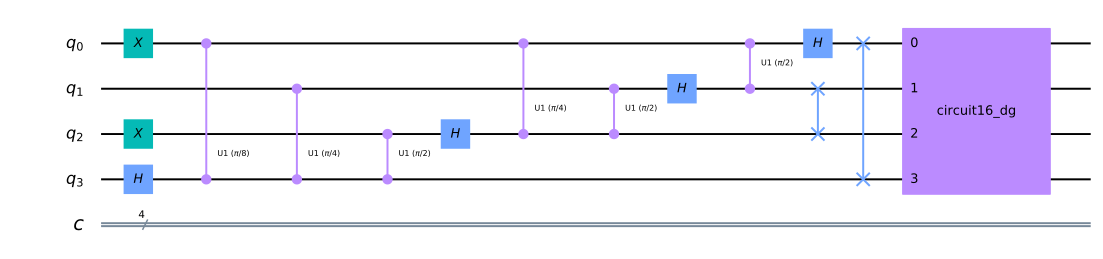

In [33]:
def qft(circuit,n):
    qft_rotations(circuit,n)
    qft_swap(circuit,n)
    return circuit
num='1010'
circuit=QuantumCircuit(len(num),len(num))
insertx(circuit, num)
qft(circuit,len(num))
inverse_qft(circuit,len(num))
circuit.draw('mpl')

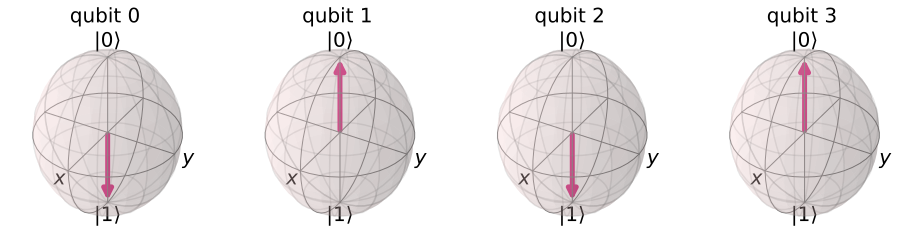

In [34]:
backend = Aer.get_backend("statevector_simulator")
statevector = execute(circuit, backend=backend).result().get_statevector()
plot_bloch_multivector(statevector)

In [35]:
circuit.measure_all()

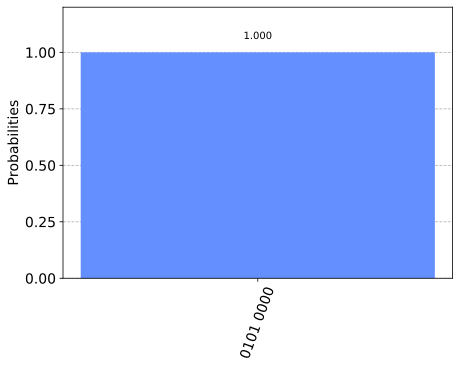

In [36]:
simulator=Aer.get_backend('qasm_simulator')
result=execute(circuit,backend=simulator).result()
counts=result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

In [1]:
IBMQ.load_account()
provider=IBMQ.get_provider('ibm-q')
qcomp=provider.get_backend('ibmq_16_melbourne')
job=execute(circuit,backend=qcomp)
from qiskit.tools.monitor import job_monitor
job_monitor(job)

NameError: name 'IBMQ' is not defined

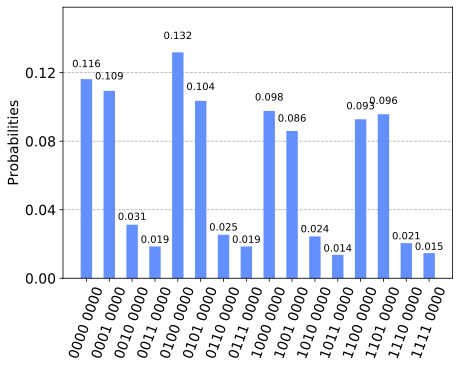

In [39]:
result=job.result()
plot_histogram(result.get_counts(circuit))

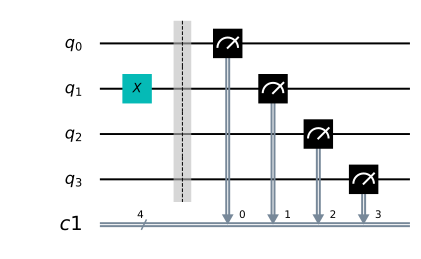

In [47]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels=complete_meas_cal(qr=circuit.qregs[0],circlabel='measerromitigationcal')
cal_circuits[2].draw(output='mpl')

In [48]:
len(cal_circuits)

16

In [52]:
cal_job=execute(cal_circuits,
                backend=qcomp,
                shots=1024,
                optimization_level=0
               )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results=cal_job.result()
            
            

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.